In [1]:
import numpy as np
import pandas as pd

from pywarper.surface import fit_surface, warp_surface
from pywarper.arbor import warp_arbor
from pywarper.utils import read_arbor_trace

In [2]:
def read_ChAT(filename):
    
    df = pd.read_csv(filename, comment='#', sep=r'\s+')
    x = df["X"].values.astype(float)
    y = df["Slice"].values.astype(float)
    z = df["Y"].values.astype(float)

    x = x + 1
    z = z + 1

    return x, y ,z

# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
off_sac = read_ChAT("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt")
on_sac = read_ChAT("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt")
rgc, nodes, edges, radii = read_arbor_trace("../tests/data/Image013-009_01_raw_latest_Uygar.swc")

In [3]:
# Fit surfaces with pygridfit under the hood
thisvzmaxmesh, xgridmax, ygridmax = fit_surface(x=off_sac[0], y=off_sac[1], z=off_sac[2], smoothness=15)
thisvzminmesh, xgridmin, ygridmin = fit_surface(x=on_sac[0], y=on_sac[1], z=on_sac[2], smoothness=15)

In [4]:
# fit quasi-conformally mapping
arbor_boundaries = np.array([nodes[:, 0].min(), nodes[:, 0].max(), nodes[:, 1].min(), nodes[:, 1].max()])
surface_mapping = warp_surface(thisvzminmesh, thisvzmaxmesh, arbor_boundaries, conformal_jump=2, verbose=True)

Warping surface...
Mapping min position (On SAC layer)...
Mapping min position completed in 3.64 seconds.
Mapping max position (Off SAC layer)...
Mapping max position completed in 3.55 seconds.


In [5]:
# warp the arbor
warped_arbor = warp_arbor(nodes, edges, radii, surface_mapping, conformal_jump=2, verbose=True)
warped_nodes = warped_arbor["nodes"]

# save as swc
# warped_arbor_arr = np.hstack([
#     warped_arbor["edges"][:, 0][:, None].astype(int),  # 1
#     np.zeros_like(warped_arbor["edges"][:, 1][:, None]),  # 2
#     warped_arbor["nodes"],  # 3, 4, 5
#     warped_arbor["radii"][:, None], # 6
#     warped_arbor["edges"][:, 1][:, None]]) # 7
# df_warped_arbor = pd.DataFrame(warped_arbor_arr, columns=["n", "t", "x", "y", "z", "radius", "parent"])
# df_warped_arbor.to_csv("warped_arbor.swc", sep="\t", index=False, header=False)

Warping nodes...
Nodes warped in 3.99 seconds.


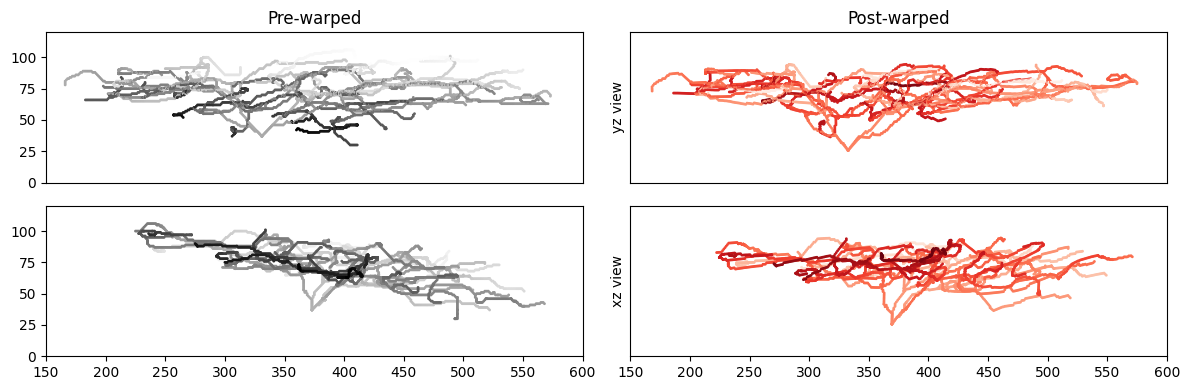

In [6]:
import matplotlib.pyplot as plt
mosaic = """
AB
CD
"""
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 4))

depth_order_pre = np.argsort(nodes[:, 1])  # ascending (far → near)
sorted_nodes_pre = nodes[depth_order_pre]

# Sort nodes for post-warped plot by depth (y-axis)
depth_order_post = np.argsort(warped_nodes[:, 1])
sorted_nodes_post = warped_nodes[depth_order_post]


# pre-warped
ax["A"].scatter(sorted_nodes_pre[:, 1], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 0], s=1, alpha=1, cmap="Grays")
ax["C"].scatter(sorted_nodes_pre[:, 0], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 1], s=1, alpha=1, cmap="Grays")
ax["A"].set_title("Pre-warped")

# post-warped
ax["B"].scatter(sorted_nodes_post[:, 1], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 0], s=1, alpha=1, cmap="Reds")
ax["D"].scatter(sorted_nodes_post[:, 0], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 1], s=1, alpha=1, cmap="Reds")

ax["B"].set_ylabel("yz view")
ax["D"].set_ylabel("xz view")

ax["B"].set_title("Post-warped")

for i in ["A", "B", "C", "D"]:

    if not i in ['C', 'D']:
        ax[i].set_xticks([])

    if not i in ['A', 'C']:
        ax[i].set_yticks([])

    ax[i].set_ylim(0, 120)
    ax[i].set_xlim(150, 600)

fig.tight_layout()

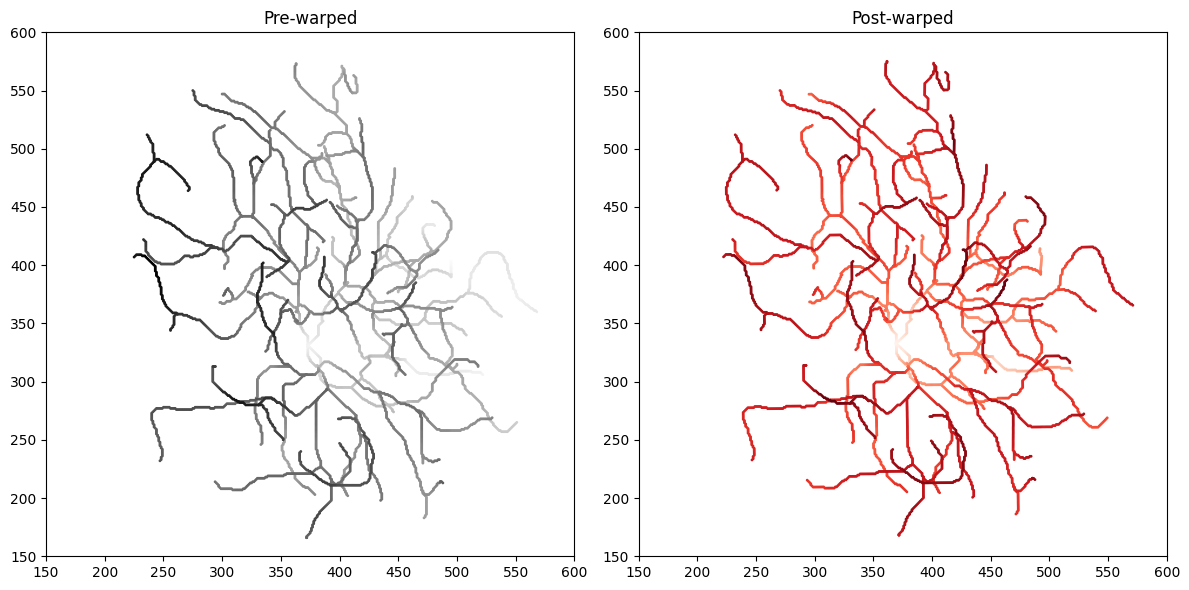

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(12, 6))

depth_order_pre = np.argsort(nodes[:, 2])  # ascending (far → near)
sorted_nodes_pre = nodes[depth_order_pre]

# Sort nodes for post-warped plot by depth (y-axis)
depth_order_post = np.argsort(warped_nodes[:, 2])
sorted_nodes_post = warped_nodes[depth_order_post]


ax[0].scatter(sorted_nodes_pre[:, 0], sorted_nodes_pre[:, 1], c=sorted_nodes_pre[:, 2], s=1, alpha=1, cmap="Grays")
ax[1].scatter(sorted_nodes_post[:, 0], sorted_nodes_post[:, 1], c=sorted_nodes_post[:, 2], s=1, alpha=1, cmap="Reds")

ax[0].set_title("Pre-warped")
ax[1].set_title("Post-warped")
for i in range(2):
    ax[i].set_ylim(150, 600)
    ax[i].set_xlim(150, 600)

fig.tight_layout()

In [8]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-04-11 13:05:59CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

pandas    : 2.2.3
matplotlib: 3.10.1
pywarper  : 0.1.0
numpy     : 2.2.4

Watermark: 2.5.0

